# Popular Data Science Questions

The goal of this project is to use the [Data Science Stack Exchange](https://datascience.stackexchange.com/) website to determine what content a data science education company should create, based on interest by subject.


##Stack Exchange
**What kind of questions are welcome on this site?**

The DSSE's help center section on questions explains that we should:

- Avoid subjective questions.
- Ask practical questions about Data Science — there are adequate sites for theoretical questions.
- Ask specific questions.
- Make questions relevant to others.

All of these characteristics should be helpful attributes to our goal.

In the help center we also learned that in addition to the sites mentioned in the Learn section, there are other two other relevant sites.

- [Open Data](https://opendata.stackexchange.com/help/on-topic) (Dataset requests)
- [Computational Science](https://scicomp.stackexchange.com/help/on-topic) (Software packages and algorithms in applied mathematics)
    

**What, other than questions, does DSSE's home subdivide into?**

On the home page we can see that we have four sections:

- [Questions](https://datascience.stackexchange.com/questions) — a list of all questions asked
- [Tags](https://datascience.stackexchange.com/tags) — a list of tags (keywords or labels that categorize questions)
- [Users](https://datascience.stackexchange.com/users) — a list of users
- [Unanswered](https://datascience.stackexchange.com/unanswered) — a list of unanswered questions

The tagging system used by Stack Exchange will be useful to solve this problem because it categorizes the questions into the different subjects we will focus on.


**What information is available in each post?**

- For both questions and answers:
    - The posts's score
    - The posts's title
    - The posts's author
    - The posts's body
- For questions only:
    - How many users have it on their feed
    - The last time the question as active
    - How many times the question was viewed
    - Related questions
    - The question's tags
    

# Stack Exchange Data Explorer
[link](https://data.stackexchange.com/datascience/query/new)

The tables here that appear promising are:
- Posts
- PostTags
- Tags
- TagSynonyms


# Getting the Data

The columns in the Post table we are interested in are:
- Id
- PostTypeId
- CreationDate
- Score
- ViewCount
- Tags
- AnswerCount
- FavoriteCount

We will only focus on questions (PostTypeId = 1) and only posts in 2019 by running the following query:

SELECT Id, CreationDate,
       Score, ViewCount, Tags,
       AnswerCount, FavoriteCount
  FROM posts
 WHERE PostTypeId = 1 AND YEAR(CreationDate) = 2019;

We will read in the data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
questions = pd.read_csv('2019_questions.csv', parse_dates = ['CreationDate'])
questions.head(10)

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,44419,2019-01-23 09:21:13,1,21,<machine-learning><data-mining>,0,NaN
1,44420,2019-01-23 09:34:01,0,25,<machine-learning><regression><linear-regressi...,0,NaN
2,44423,2019-01-23 09:58:41,2,1651,<python><time-series><forecast><forecasting>,0,NaN
3,44427,2019-01-23 10:57:09,0,55,<machine-learning><scikit-learn><pca>,1,NaN
4,44428,2019-01-23 11:02:15,0,19,<dataset><bigdata><data><speech-to-text>,0,NaN
5,44430,2019-01-23 11:13:32,0,283,<fuzzy-logic>,1,NaN
6,44432,2019-01-23 11:17:46,1,214,<time-series><anomaly-detection><online-learning>,0,1.0
7,44436,2019-01-23 12:49:39,0,9,<matrix-factorisation>,0,NaN
8,44437,2019-01-23 13:04:11,0,7,<correlation><naive-bayes-classifier>,0,NaN
9,44438,2019-01-23 13:16:29,0,584,<machine-learning><python><deep-learning><kera...,1,NaN


In [5]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
Id               8839 non-null int64
CreationDate     8839 non-null datetime64[ns]
Score            8839 non-null int64
ViewCount        8839 non-null int64
Tags             8839 non-null object
AnswerCount      8839 non-null int64
FavoriteCount    1407 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 483.5+ KB


The FavoriteCount column has missing values, because no users have favorited that post. We can change this NaN value to 0.

In [6]:
questions['FavoriteCount'].fillna(0, inplace = True)
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
Id               8839 non-null int64
CreationDate     8839 non-null datetime64[ns]
Score            8839 non-null int64
ViewCount        8839 non-null int64
Tags             8839 non-null object
AnswerCount      8839 non-null int64
FavoriteCount    8839 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 483.5+ KB


In [7]:
questions['FavoriteCount'] = questions['FavoriteCount'].astype(int)

In [10]:
questions.dtypes

Id                        int64
CreationDate     datetime64[ns]
Score                     int64
ViewCount                 int64
Tags                     object
AnswerCount               int64
FavoriteCount             int64
dtype: object

New we will clean the tags column

In [11]:
questions['Tags'] = questions['Tags'].str.replace('><', ',').str.replace('<','').str.replace('>','').str.split(',')
questions['Tags'].head()

0                      [machine-learning, data-mining]
1    [machine-learning, regression, linear-regressi...
2         [python, time-series, forecast, forecasting]
3                [machine-learning, scikit-learn, pca]
4             [dataset, bigdata, data, speech-to-text]
Name: Tags, dtype: object

The tags are now contained in a list rather than one long string


**Most used and Most viewed**

I will now determine the most popular tags. I will condider two popularity proxies: how often each tag was used and how many time a question with that tag was viewed.

In [14]:
#Most Used

tag_count = dict()
for tags in questions['Tags']:
    for tag in tags:
        if tag in tag_count:
            tag_count[tag]+= 1
        else:
            tag_count[tag] = 1
            
tag_count = pd.DataFrame.from_dict(tag_count, orient='index')
tag_count.rename(columns={0: 'Count'}, inplace=True)
tag_count.sort_values('Count', ascending=False, inplace=True)
tag_count.head(10)

,Count
machine-learning,2693
python,1814
deep-learning,1220
neural-network,1055
keras,935
classification,685
tensorflow,584
scikit-learn,540
nlp,493
cnn,489


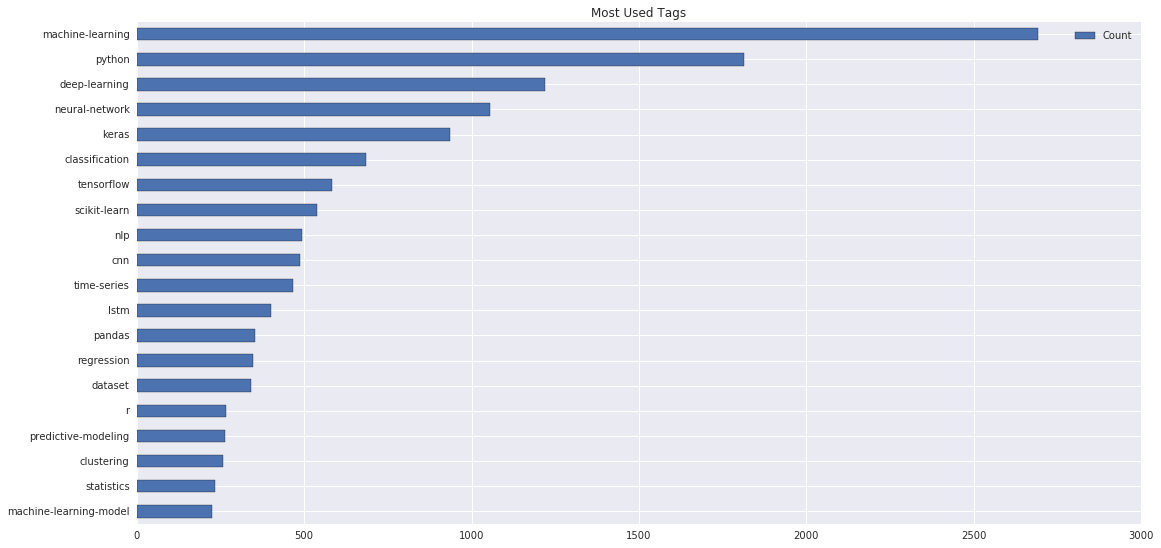

In [20]:
most_used = tag_count.head(20)
most_used.sort_values('Count').plot(kind='barh', figsize=(18,9), title='Most Used Tags')

This bar plot shows how often the top 20 tags are used.

I will new repeat the same process for views.

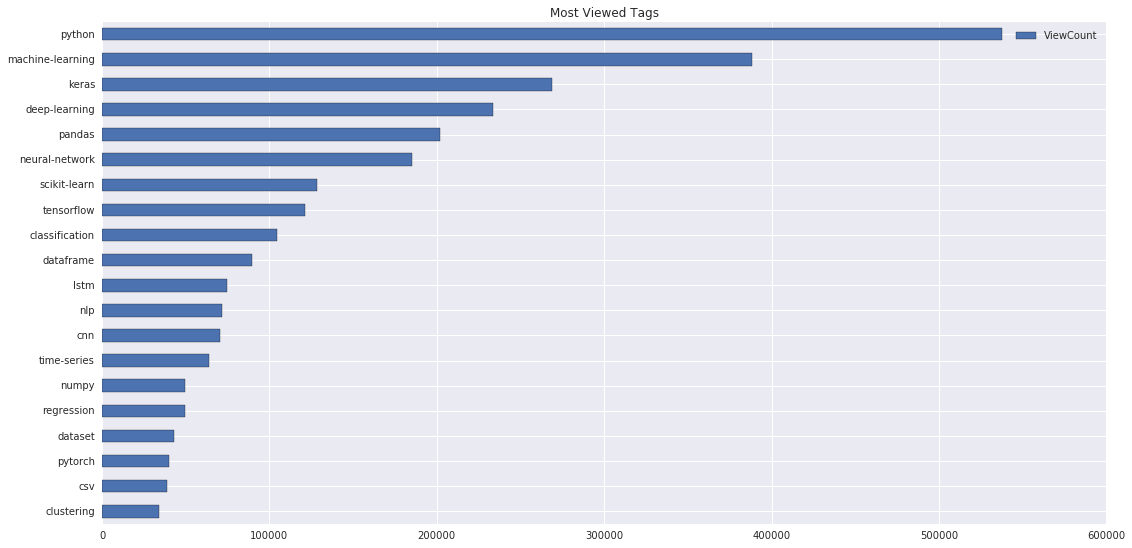

In [21]:
tag_views = dict()

for index, row in questions.iterrows():
    for tag in row['Tags']:
        if tag in tag_views:
            tag_views[tag] += row['ViewCount']
        else:
            tag_views[tag] = row['ViewCount']

tag_views = pd.DataFrame.from_dict(tag_views, orient='index')
tag_views.rename(columns={0: 'ViewCount'}, inplace=True)
most_viewed = tag_views.sort_values('ViewCount').tail(20)
most_viewed.plot(kind='barh', figsize=(18,9), title="Most Viewed Tags")

Most of the values in most_used are also in most_viewed.

I will find the values that are in most_used but not in most_viewed, and vice-versa

In [22]:
in_used = pd.merge(most_used, most_viewed, how="left", left_index=True, right_index=True)
in_viewed = pd.merge(most_used, most_viewed, how="right", left_index=True, right_index=True)

In [23]:
in_used

,Count,ViewCount
machine-learning,2693,388499.0
python,1814,537585.0
deep-learning,1220,233628.0
neural-network,1055,185367.0
keras,935,268608.0
classification,685,104457.0
tensorflow,584,121369.0
scikit-learn,540,128110.0
nlp,493,71382.0
cnn,489,70349.0


In [24]:
in_viewed

,Count,ViewCount
clustering,257.0,33928
csv,NaN,38654
pytorch,NaN,40240
dataset,340.0,43151
regression,347.0,49451
numpy,NaN,49767
time-series,466.0,64134
cnn,489.0,70349
nlp,493.0,71382
lstm,402.0,74458


The tags in most_used but not in most_viewed are:
- r
- predictive-modeling
- machine-learning-model

The tags in most_viewed but not in most_used are:
- csv
- pytorch
- numpy
- DataFrame

**Relationships between tags**
I will gauge the relationships between tags by counting how often different tags appear together.



In [25]:
all_tags = list(tag_count.index)
associations = pd.DataFrame(index=all_tags, columns=all_tags)
associations.fillna(0, inplace=True)

# For each lists of tags in questions['Tags'], I will increment the intervening tags by 1. 
for tags in questions["Tags"]:
    associations.loc[tags, tags] += 1

# This DF will be very large, so I will focus on only the most used tags

most_used_rel = associations.loc[most_used.index, most_used.index]


In [27]:
most_used_rel

,machine-learning,python,deep-learning,neural-network,keras,classification,tensorflow,scikit-learn,nlp,cnn,time-series,lstm,pandas,regression,dataset,r,predictive-modeling,clustering,statistics,machine-learning-model
machine-learning,2693,499,429,366,195,259,106,188,113,124,131,71,62,119,99,63,123,61,89,139
python,499,1814,160,137,280,98,167,235,71,62,105,61,244,59,53,24,35,45,35,37
deep-learning,429,160,1220,305,247,59,136,16,72,160,44,103,1,21,32,5,32,2,12,19
neural-network,366,137,305,1055,235,65,108,24,24,118,33,69,1,42,20,9,13,8,11,10
keras,195,280,247,235,935,58,256,34,23,116,51,133,3,31,13,10,11,0,3,17
classification,259,98,59,65,58,685,20,47,35,20,25,20,3,34,28,10,27,12,19,21
tensorflow,106,167,136,108,256,20,584,15,11,57,9,43,3,9,9,1,6,0,0,9
scikit-learn,188,235,16,24,34,47,15,540,12,0,12,2,37,37,9,1,12,24,6,18
nlp,113,71,72,24,23,35,11,12,493,7,0,19,3,2,11,4,1,9,3,4
cnn,124,62,160,118,116,20,57,0,7,489,8,24,1,6,11,2,6,0,1,4


I will now put this DF into a heatmap in order to visualize relations. Before I do this, however, I will take out values where equal tags intersect in order to better visualize.

In [30]:
for i in range(most_used_rel.shape[0]):
    most_used_rel.iloc[i,i] = pd.np.NaN

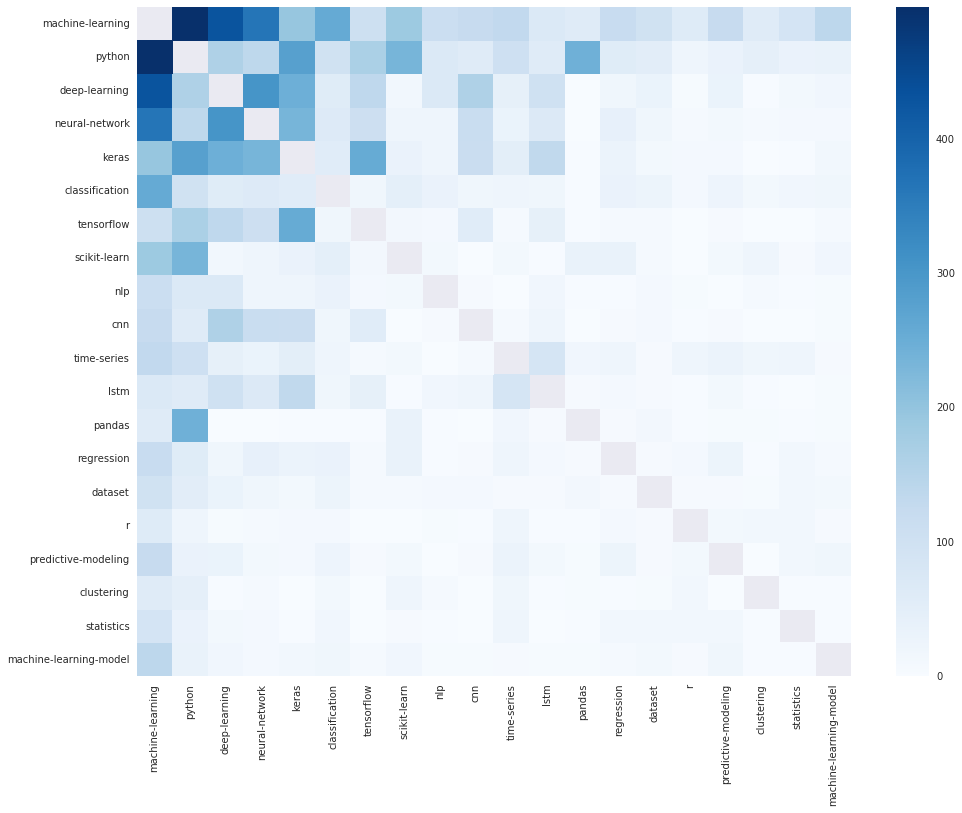

In [32]:
plt.figure(figsize=(16,12))
sns.heatmap(most_used_rel, cmap = 'Blues', annot=False)

The most used tags seem to have the strongest relationships, as the darkest colors are located in the top left. However, this could simply be because popular tags are more likely to be used, and thus will appear more often with other more popular tags.

**Is deep learning just a fad?**

The file 'all_questions.csv' holds the result of the query below:
SELECT Id, CreationDate, Tags
  FROM posts
 WHERE PostTypeId = 1;

I will track deep learning interest across time. To do this, I will:
- Count how many deep learning questions are asked per time period
- Count the total amount of questions per time period
- Determine how many deep learning questions there are relative to the total amount of questions per time period

In [33]:
all_q = pd.read_csv('all_questions.csv', parse_dates=['CreationDate'])
all_q.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21576 entries, 0 to 21575
Data columns (total 3 columns):
Id              21576 non-null int64
CreationDate    21576 non-null datetime64[ns]
Tags            21576 non-null object
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 505.8+ KB


In [34]:
# Transform tags like before

all_q['Tags'] = all_q['Tags'].str.replace('><', ',').str.replace('<','').str.replace('>','').str.split(',')

all_q.head()

,Id,CreationDate,Tags
0,45416,2019-02-12 00:36:29,"[python, keras, tensorflow, cnn, probability]"
1,45418,2019-02-12 00:50:39,[neural-network]
2,45422,2019-02-12 04:40:51,"[python, ibm-watson, chatbot]"
3,45426,2019-02-12 04:51:49,[keras]
4,45427,2019-02-12 05:08:24,"[r, predictive-modeling, machine-learning-mode..."


In order to classify a question as being related to deep learning, we will check if its tags are related to deep learning. The tags in most_used related to deep learning are:
- lstm
- cnn
- scikit-learn
- tensorflow
- keras
- neural-network
- deep-learning

In [35]:
def deep_learning(tags):
    for tag in tags:
        if tag in ["lstm", "cnn", "scikit-learn", "tensorflow",
                   "keras", "neural-network", "deep-learning"]:
            return 1
    return 0

all_q['DeepLearning'] = all_q['Tags'].apply(deep_learning)


In [36]:
all_q.sort_values('CreationDate', ascending=False)

,Id,CreationDate,Tags,DeepLearning
21324,66691,2020-01-19 03:01:03,"[python, pandas, anaconda, statsmodels]",0
21323,66690,2020-01-19 02:21:53,"[keras, gan]",1
21322,66686,2020-01-19 00:49:00,"[data-mining, bigdata, association-rules]",0
21321,66685,2020-01-18 23:56:27,"[machine-learning, nlp, named-entity-recognition]",0
21320,66684,2020-01-18 21:17:34,"[machine-learning, python, matplotlib, csv]",0
21319,66683,2020-01-18 20:11:59,"[tensorflow, object-detection]",1
21318,66682,2020-01-18 19:12:33,"[keras, time-series, lstm]",1
21317,66681,2020-01-18 18:06:40,"[neural-network, training, matlab]",1
21316,66679,2020-01-18 14:41:53,"[keras, image-classification, overfitting, pyt...",1
21266,66673,2020-01-18 13:46:20,"[python, recurrent-neural-net, scipy]",0


I will track the data by quarterly. I will remove all questions from 2020 because the DF only contains data through January 19, 2020, and create a column that tracks the quarter that the question was asked.

In [37]:
all_q = all_q[all_q['CreationDate'].dt.year < 2020]


In [38]:
def get_quarter(datetime):
    year = str(datetime.year)[-2:]
    quarter = str(((datetime.month-1) // 3) + 1)
    return "{y}Q{q}".format(y=year, q=quarter)

all_q["Quarter"] = all_q["CreationDate"].apply(get_quarter)

all_q.head(10)

,Id,CreationDate,Tags,DeepLearning,Quarter
0,45416,2019-02-12 00:36:29,"[python, keras, tensorflow, cnn, probability]",1,19Q1
1,45418,2019-02-12 00:50:39,[neural-network],1,19Q1
2,45422,2019-02-12 04:40:51,"[python, ibm-watson, chatbot]",0,19Q1
3,45426,2019-02-12 04:51:49,[keras],1,19Q1
4,45427,2019-02-12 05:08:24,"[r, predictive-modeling, machine-learning-mode...",0,19Q1
5,45428,2019-02-12 05:43:18,[cnn],1,19Q1
6,45430,2019-02-12 06:20:30,"[machine-learning, learning]",0,19Q1
7,45431,2019-02-12 07:26:56,[machine-learning],0,19Q1
8,45433,2019-02-12 08:56:23,"[python, keras, tensorflow, lstm]",1,19Q1
9,45434,2019-02-12 09:09:01,"[neural-network, feature-selection, mlp]",1,19Q1


In [40]:
quarterly = all_q.groupby('Quarter').agg({"DeepLearning": ['sum', 'size']})
quarterly.columns = ['DeepLearningQuestions', 'TotalQuestions']
quarterly["DeepLearningRate"] = quarterly["DeepLearningQuestions"]/quarterly["TotalQuestions"]
quarterly.reset_index(inplace=True)
quarterly.tail(10)

,Quarter,DeepLearningQuestions,TotalQuestions,DeepLearningRate
13,17Q3,247,714,0.345938
14,17Q4,353,898,0.393096
15,18Q1,554,1221,0.453726
16,18Q2,566,1448,0.390884
17,18Q3,685,1512,0.453042
18,18Q4,531,1294,0.410355
19,19Q1,804,1987,0.404630
20,19Q2,935,2393,0.390723
21,19Q3,941,2394,0.393066
22,19Q4,809,2036,0.397348


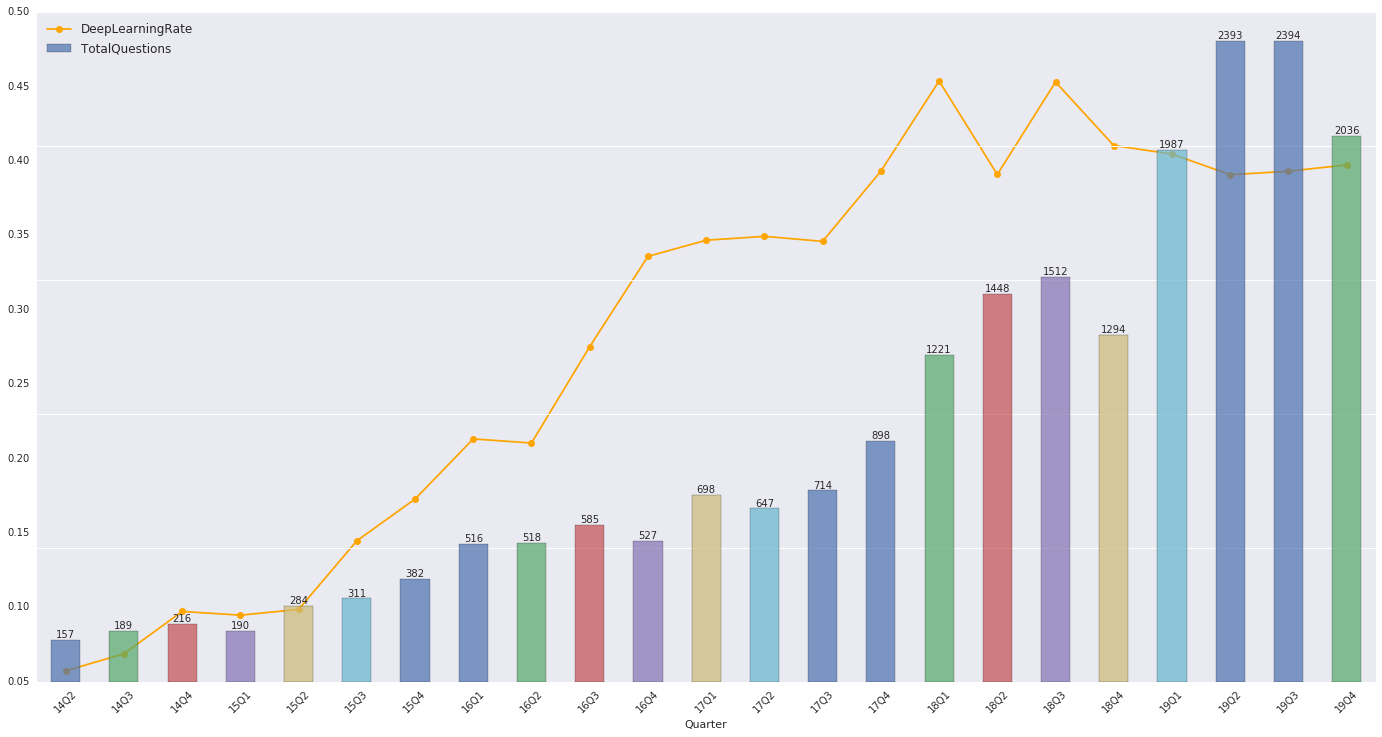

In [47]:
ax1 = quarterly.plot(kind="line",x="Quarter", y="DeepLearningRate", linestyle="-", marker="o", color="orange", figsize=(24,12))
ax2 = quarterly.plot(kind="bar", x="Quarter", y="TotalQuestions", ax=ax1, secondary_y=True, alpha=0.7, rot=45)

for idx, t in quarterly["TotalQuestions"].iteritems():
    ax2.text(idx, t, str(t), ha="center", va="bottom")
xlims = ax1.get_xlim()

ax1.get_legend().remove()

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles=handles1 + handles2,
           labels=labels1 + labels2,
           loc="upper left", prop={"size": 12})


for ax in (ax1, ax2):
    for where in ("top", "right"):
        ax.spines[where].set_visible(False)
        ax.tick_params(right=False, labelright=False)



It appears that interest in deep learning has increased markedly since the creation of DSSE, and is begining to plateau. There is still a large interest in deep learning, so I recommend that we create deep learning content.